# Building an Image Classification Model Using AlexNet

In [67]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [68]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((227, 227)), #Alexnet expects an input size of 227 x 227 x 3
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) 
])

In [69]:
# Paths to the data
train_data_path = r'C:\Users\Praphul\Downloads\Human Action Recognition_New/train'
test_data_path = r'C:\Users\Praphul\Downloads\Human Action Recognition_New/test'

In [70]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

##### Run all the cells above till here

### AlexNet Architecture

In [80]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Calculate the size of the feature map after the last pooling layer
        self.fc_input_dim = 256 * 6 * 6  # This is for input size 224x224
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.fc_input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

Changes in the architecture are as follows:


1)__Increased Depth of Convolutional Layers:__ The AlexNet model uses more layers and deeper configurations. Starting with fewer feature channels, it progressively increases the depth across its layers. This contrasts sharply with LeNet, which uses a much simpler and shallower layer structure.


2)__Use of Batch Normalization:__ Each convolutional layer in AlexNet is followed by batch normalization, which helps in stabilizing the learning process by normalizing the input layer by adjusting and scaling activations. LeNet does not include batch normalization, which makes AlexNet better suited for training on larger datasets and more complex models.


3)__Advanced Activation Functions:__ AlexNet incorporates the ReLU (Rectified Linear Unit) activation function throughout its architecture, which helps to solve the vanishing gradient problem common in networks using sigmoid or tanh functions. LeNet traditionally uses sigmoid or tanh, which are less effective at preserving gradients during deep learning training.


4)__Increased and Varied Pooling Layers:__ AlexNet includes multiple max pooling layers that perform downsampling operation more frequently compared to LeNet. This reduces the spatial size of the representation, decreases the number of parameters and computation in the network, and hence, also controls overfitting.


5)__Integration of Dropout:__ In the classifier section of AlexNet, dropout layers are introduced. Dropout is a form of regularization that helps in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training time, which helps in making the model robust and less likely to rely on any one feature.


6)__Complex Classifier Structure:__ AlexNet's classifier is more complex, using three fully connected layers with dropout and ReLU activation functions between them. This is a significant escalation from LeNet’s typically one or two-layer classifiers. This complexity allows AlexNet to make more fine-grained classifications based on the richer feature hierarchies developed in the convolutional layers.


7)__Scalability to Higher Resolution Inputs:__ AlexNet is structured to handle higher resolution input images better than LeNet. The initial convolutional layer uses a larger receptive field (11x11 with a stride of 4), which is suitable for larger input images, whereas LeNet is optimized for smaller images typical of earlier datasets like MNIST.


In [81]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
device

device(type='cuda')

In [83]:
# Initialize the model
model = AlexNet().to(device)

In [84]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [85]:
# Create DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [86]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

100%|██████████| 112/112 [00:16<00:00,  6.93it/s]


Epoch [1/20], Train Loss: 1.6337, Train Accuracy: 20.76%
Test Loss: 1.6051, Test Accuracy: 20.00%
Updated best model with accuracy: 20.00%


100%|██████████| 112/112 [00:13<00:00,  8.52it/s]


Epoch [2/20], Train Loss: 1.5868, Train Accuracy: 25.55%
Test Loss: 1.5803, Test Accuracy: 24.92%
Updated best model with accuracy: 24.92%


100%|██████████| 112/112 [00:13<00:00,  8.29it/s]


Epoch [3/20], Train Loss: 1.5534, Train Accuracy: 28.60%
Test Loss: 1.5811, Test Accuracy: 25.08%


100%|██████████| 112/112 [00:13<00:00,  8.34it/s]


Epoch [4/20], Train Loss: 1.5866, Train Accuracy: 24.73%
Test Loss: 1.6176, Test Accuracy: 22.86%


100%|██████████| 112/112 [00:13<00:00,  8.46it/s]


Epoch [5/20], Train Loss: 1.5812, Train Accuracy: 24.87%
Test Loss: 1.5651, Test Accuracy: 25.71%
Updated best model with accuracy: 25.71%


100%|██████████| 112/112 [00:13<00:00,  8.38it/s]


Epoch [6/20], Train Loss: 1.5842, Train Accuracy: 24.99%
Test Loss: 1.5626, Test Accuracy: 26.03%
Updated best model with accuracy: 26.03%


100%|██████████| 112/112 [00:13<00:00,  8.35it/s]


Epoch [7/20], Train Loss: 1.5633, Train Accuracy: 28.54%
Test Loss: 1.5572, Test Accuracy: 27.46%
Updated best model with accuracy: 27.46%


100%|██████████| 112/112 [00:13<00:00,  8.23it/s]


Epoch [8/20], Train Loss: 1.5460, Train Accuracy: 29.72%
Test Loss: 1.4977, Test Accuracy: 34.13%
Updated best model with accuracy: 34.13%


100%|██████████| 112/112 [00:13<00:00,  8.26it/s]


Epoch [9/20], Train Loss: 1.5519, Train Accuracy: 29.27%
Test Loss: 1.5659, Test Accuracy: 27.78%


100%|██████████| 112/112 [00:13<00:00,  8.34it/s]


Epoch [10/20], Train Loss: 1.5052, Train Accuracy: 33.36%
Test Loss: 1.5224, Test Accuracy: 33.17%


100%|██████████| 112/112 [00:13<00:00,  8.16it/s]


Epoch [11/20], Train Loss: 1.4429, Train Accuracy: 37.42%
Test Loss: 1.5432, Test Accuracy: 36.67%


100%|██████████| 112/112 [00:13<00:00,  8.19it/s]


Epoch [12/20], Train Loss: 1.4048, Train Accuracy: 39.97%
Test Loss: 1.3843, Test Accuracy: 42.54%
Updated best model with accuracy: 42.54%


100%|██████████| 112/112 [00:13<00:00,  8.43it/s]


Epoch [13/20], Train Loss: 1.3495, Train Accuracy: 44.01%
Test Loss: 1.3107, Test Accuracy: 47.30%
Updated best model with accuracy: 47.30%


100%|██████████| 112/112 [00:13<00:00,  8.32it/s]


Epoch [14/20], Train Loss: 1.3137, Train Accuracy: 46.05%
Test Loss: 1.3989, Test Accuracy: 47.46%


100%|██████████| 112/112 [00:13<00:00,  8.08it/s]


Epoch [15/20], Train Loss: 1.2797, Train Accuracy: 47.31%
Test Loss: 1.3353, Test Accuracy: 43.33%


100%|██████████| 112/112 [00:14<00:00,  8.00it/s]


Epoch [16/20], Train Loss: 1.2196, Train Accuracy: 52.02%
Test Loss: 1.2385, Test Accuracy: 51.43%
Updated best model with accuracy: 51.43%


100%|██████████| 112/112 [00:13<00:00,  8.12it/s]


Epoch [17/20], Train Loss: 1.1873, Train Accuracy: 52.89%
Test Loss: 1.3325, Test Accuracy: 48.41%


100%|██████████| 112/112 [00:13<00:00,  8.44it/s]


Epoch [18/20], Train Loss: 1.1694, Train Accuracy: 53.22%
Test Loss: 1.2596, Test Accuracy: 52.54%


100%|██████████| 112/112 [00:13<00:00,  8.09it/s]


Epoch [19/20], Train Loss: 1.0846, Train Accuracy: 56.92%
Test Loss: 1.2143, Test Accuracy: 53.02%
Updated best model with accuracy: 53.02%


100%|██████████| 112/112 [00:13<00:00,  8.27it/s]


Epoch [20/20], Train Loss: 1.0638, Train Accuracy: 57.23%
Test Loss: 1.2496, Test Accuracy: 52.38%


### Plot: Epochs vs Train Loss and Test

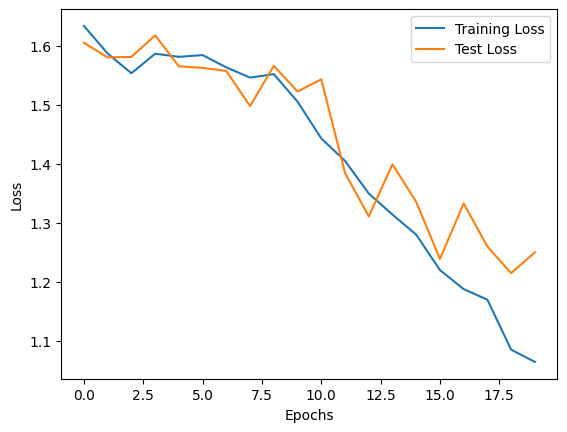

In [88]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()